# Investigation of Distances of Brain Volume and FA

In this notebook, we will investigate which brain regions have significantly different patterns of connectivity by comparing the differences in brain volume and FA.

To do so, we will compute a distance matrix that encode the differences in brain volume or FA between each pair of regions for each mouse. We will then obtain a low-dimensional representations of the distance matrices using a joint embedding technique called omnibus embedding. This will give us a Euclidean representation of the distance matrices and allow for region-wise comparision. Given the above embedding, we will separate out two different analysis:
1. Investigation of effect of gender and different alleles (HN and non-HN).
2. Investigation of effect of gender and diet (control and HFD).

The analysis were separated into these categories since not all possible combination of data were collected. For example, not all genotypes and gender combinations of HFD with non-HN alleles. As such, we need to perform two separate analysis in order to understand the effect of the HN allele and diet.

To perform the analysis, we will use the embeddings and test if each region is significantly different given some combination of groups (e.g. certain labels). For example, we will test of there is a difference among the APOE2, 3, 4 genotypes while considering both gender, male and females, as well as the two HN and non-HN alleles. We will then run subsequent analysis comparing subgroups. For example, instead of examining all three genotypes, we can compare APOE2 and 3 while considering gender and alleles. Our choice of test statistic will be based on distance correlations, and the p-value will be given by a chi-squared approximations for fast computations.

We will perform the test separately on brain volume and FA. Once a p-value for each brain region is obtained, we will correct the p-values using Bonferroni correction. We then combine the p-values obtained from volume and FA into a single composite p-value using the harmonic mean method. Given these combined p-values, any values below the significance level of a=0.05 are considered significant results.

In [1]:
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from hyppo.independence import Dcorr
from hyppo.tools import chi2_approx
from sklearn.preprocessing import OneHotEncoder
from statsmodels.stats.multitest import multipletests

In [2]:
volumes = pd.read_csv("../data/new/processed/volumes.csv")
meta = pd.read_csv("../data/new/processed/meta.csv")

meta.head()

vols = []
for idx, row in meta.iterrows():
    ID = row["ID"]
    vols.append(volumes[[ID]].values.ravel())

vols = np.vstack(vols)
vols /= vols.sum(axis=1, keepdims=True)

In [3]:
# Column labels
# APOE2, APOE3, APOE4, NON-HN, HN, Female, Male
enc = OneHotEncoder(handle_unknown="ignore")
tmp = meta[["Genotype", "Sex", "Diet", "Allele"]]
enc.fit(tmp)

multiway_table = enc.transform(tmp).toarray()

enc.get_feature_names_out()

lookup = {key: val for key, val in zip(enc.get_feature_names_out(), range(12))}

# %%
groups = [
    ["Sex_Female", "Sex_Male", "Diet_Control", "Allele_HN", "Allele_Non-HN"],
    ["Sex_Female", "Diet_Control", "Allele_HN", "Allele_Non-HN"],
    ["Sex_Male", "Diet_Control", "Allele_HN", "Allele_Non-HN"],
    ["Sex_Female", "Sex_Male", "Diet_Control", "Allele_HN"],
    ["Sex_Female", "Sex_Male", "Diet_Control", "Allele_Non-HN"],
    ["Sex_Female", "Diet_Control", "Allele_HN"],
    ["Sex_Female", "Diet_Control", "Allele_Non-HN"],
    ["Sex_Male", "Diet_Control", "Allele_HN"],
    ["Sex_Male", "Diet_Control", "Allele_Non-HN"],
    ["Diet_Control", "Allele_HN", "Allele_Non-HN"],
    ["Diet_Control", "Allele_HN"],
    ["Diet_Control", "Allele_Non-HN"],
    ["Sex_Male", "Diet_Control"],
    ["Sex_Female", "Diet_Control"],
    ["Sex_Male", "Sex_Female", "Diet_Control"],
    ["Diet_Control"],
]

genotype_groups = []
for i in [3, 2]:
    genotype_groups += list(
        combinations(["Genotype_APOE22", "Genotype_APOE33", "Genotype_APOE44"], i)
    )
genotype_groups = [list(i) for i in genotype_groups]

TEST_LIST = [i + j for i in genotype_groups for j in groups]

# %%
# Run node wise

res = []

for test in TEST_LIST:
    lookup_codes = [lookup[i] for i in test]
    test_multiway_table = multiway_table[:, lookup_codes]
    maximum = np.max(test_multiway_table.sum(axis=1))

    idx = test_multiway_table.sum(axis=1) == maximum

    x = vols[idx]
    y = test_multiway_table[idx]
    tmp_res = []
    for i in range(x.shape[1]):
        stat, pval = chi2_approx(Dcorr().statistic, x[:, [i]], y)
        tmp_res.append(pval)

    apoe2 = True if "Genotype_APOE22" in test else False
    apoe3 = True if "Genotype_APOE33" in test else False
    apoe4 = True if "Genotype_APOE44" in test else False
    female = True if "Sex_Female" in test else False
    male = True if "Sex_Male" in test else False
    hn = True if "Allele_HN" in test else False
    non_hn = True if "Allele_Non-HN" in test else False
    multiway = True if (female and male) or (hn and non_hn) else False

    n = x.shape[0]

    res.append(
        [
            multiway,
            apoe2,
            apoe3,
            apoe4,
            female,
            male,
            hn,
            non_hn,
            n,
            *tmp_res,
        ]
    )

columns = [
    "Multiway",
    "APOE2",
    "APOE3",
    "APOE4",
    "Female",
    "Male",
    "HN",
    "Non-HN",
    "N",
] + volumes.structure.to_list()

df = pd.DataFrame(res, columns=columns)

K = []

for idx, row in df.iterrows():
    total = row[["APOE2", "APOE3", "APOE4"]].sum()
    if row[["Female", "Male"]].sum() > 0:
        total *= row[["Female", "Male"]].sum()
    if row[["HN", "Non-HN"]].sum() > 0:
        total *= row[["HN", "Non-HN"]].sum()
    K.append(total)

df["K"] = K

df.sort_values(
    by=["N", "K", "Female", "Male", "Non-HN", "HN", "K"], inplace=True, ascending=False
)

i_new = []
for idx, row in df.iterrows():
    K = row["K"]
    N = row["N"]
    if row["Multiway"]:
        multiway = "X"
    else:
        multiway = " "

    geno_row = row[["APOE2", "APOE3", "APOE4"]]
    if np.all(geno_row == [True, True, True]):
        genotype = "APOE 2, 3, 4"
    elif np.all(geno_row == [True, True, False]):
        genotype = "APOE 2, 3,  "
    elif np.all(geno_row == [True, False, True]):
        genotype = "APOE 2,    4"
    elif np.all(geno_row == [False, True, True]):
        genotype = "APOE    3, 4"

    gender_row = row[["Female", "Male"]]
    if np.all(gender_row == [True, True]):
        gender = "F, M"
    elif np.all(gender_row == [False, True]):
        gender = "   M"
    elif np.all(gender_row == [True, False]):
        gender = "F   "
    else:
        gender = "    "

    allele_row = row[["HN", "Non-HN"]]
    if np.all(allele_row == [True, True]):
        allele = "HN, Non-HN"
    elif np.all(allele_row == [False, True]):
        allele = "    Non-HN"
    elif np.all(allele_row == [True, False]):
        allele = "HN        "
    else:
        allele = "          "

    index = f"{K:2d} | {N:3d} | {multiway} | {genotype} | {gender} | {allele}"
    i_new.append(index)


df.index = i_new

pvalues = df.iloc[:, 9:-1].copy()

sig, corrected_pvals, b, alpha = multipletests(
    pvalues.values.ravel(), method="bonferroni"
)

pvalues.iloc[:, :] = corrected_pvals.reshape(len(TEST_LIST), -1)
mask = np.select([pvalues < 0.05, pvalues >= 0.05], ["X", ""], default=pvalues)

node_labels = pd.read_excel("../data/raw/CHASSSYMM3AtlasLegends.xlsx")[:-1]
node_labels["Abbreviation-Hemisphere"] = (
    node_labels["Abbreviation"] + "-" + node_labels["Hemisphere"].str[0]
)

left_nodes = (node_labels["Hemisphere"] == "Left").values
right_nodes = (node_labels["Hemisphere"] == "Right").values

nodes_to_choose = ((pvalues <= 0.05).sum() >= 1).values
# pvalues.columns = node_labels["Abbreviation"].values
pvalues.columns = node_labels["Abbreviation-Hemisphere"].values
# pvalues = pvalues[sorted(pvalues.columns)]

left_idx = nodes_to_choose & left_nodes
right_idx = nodes_to_choose & right_nodes

rows_to_choose = ((pvalues <= 0.05).sum(axis=1) >= 1).values

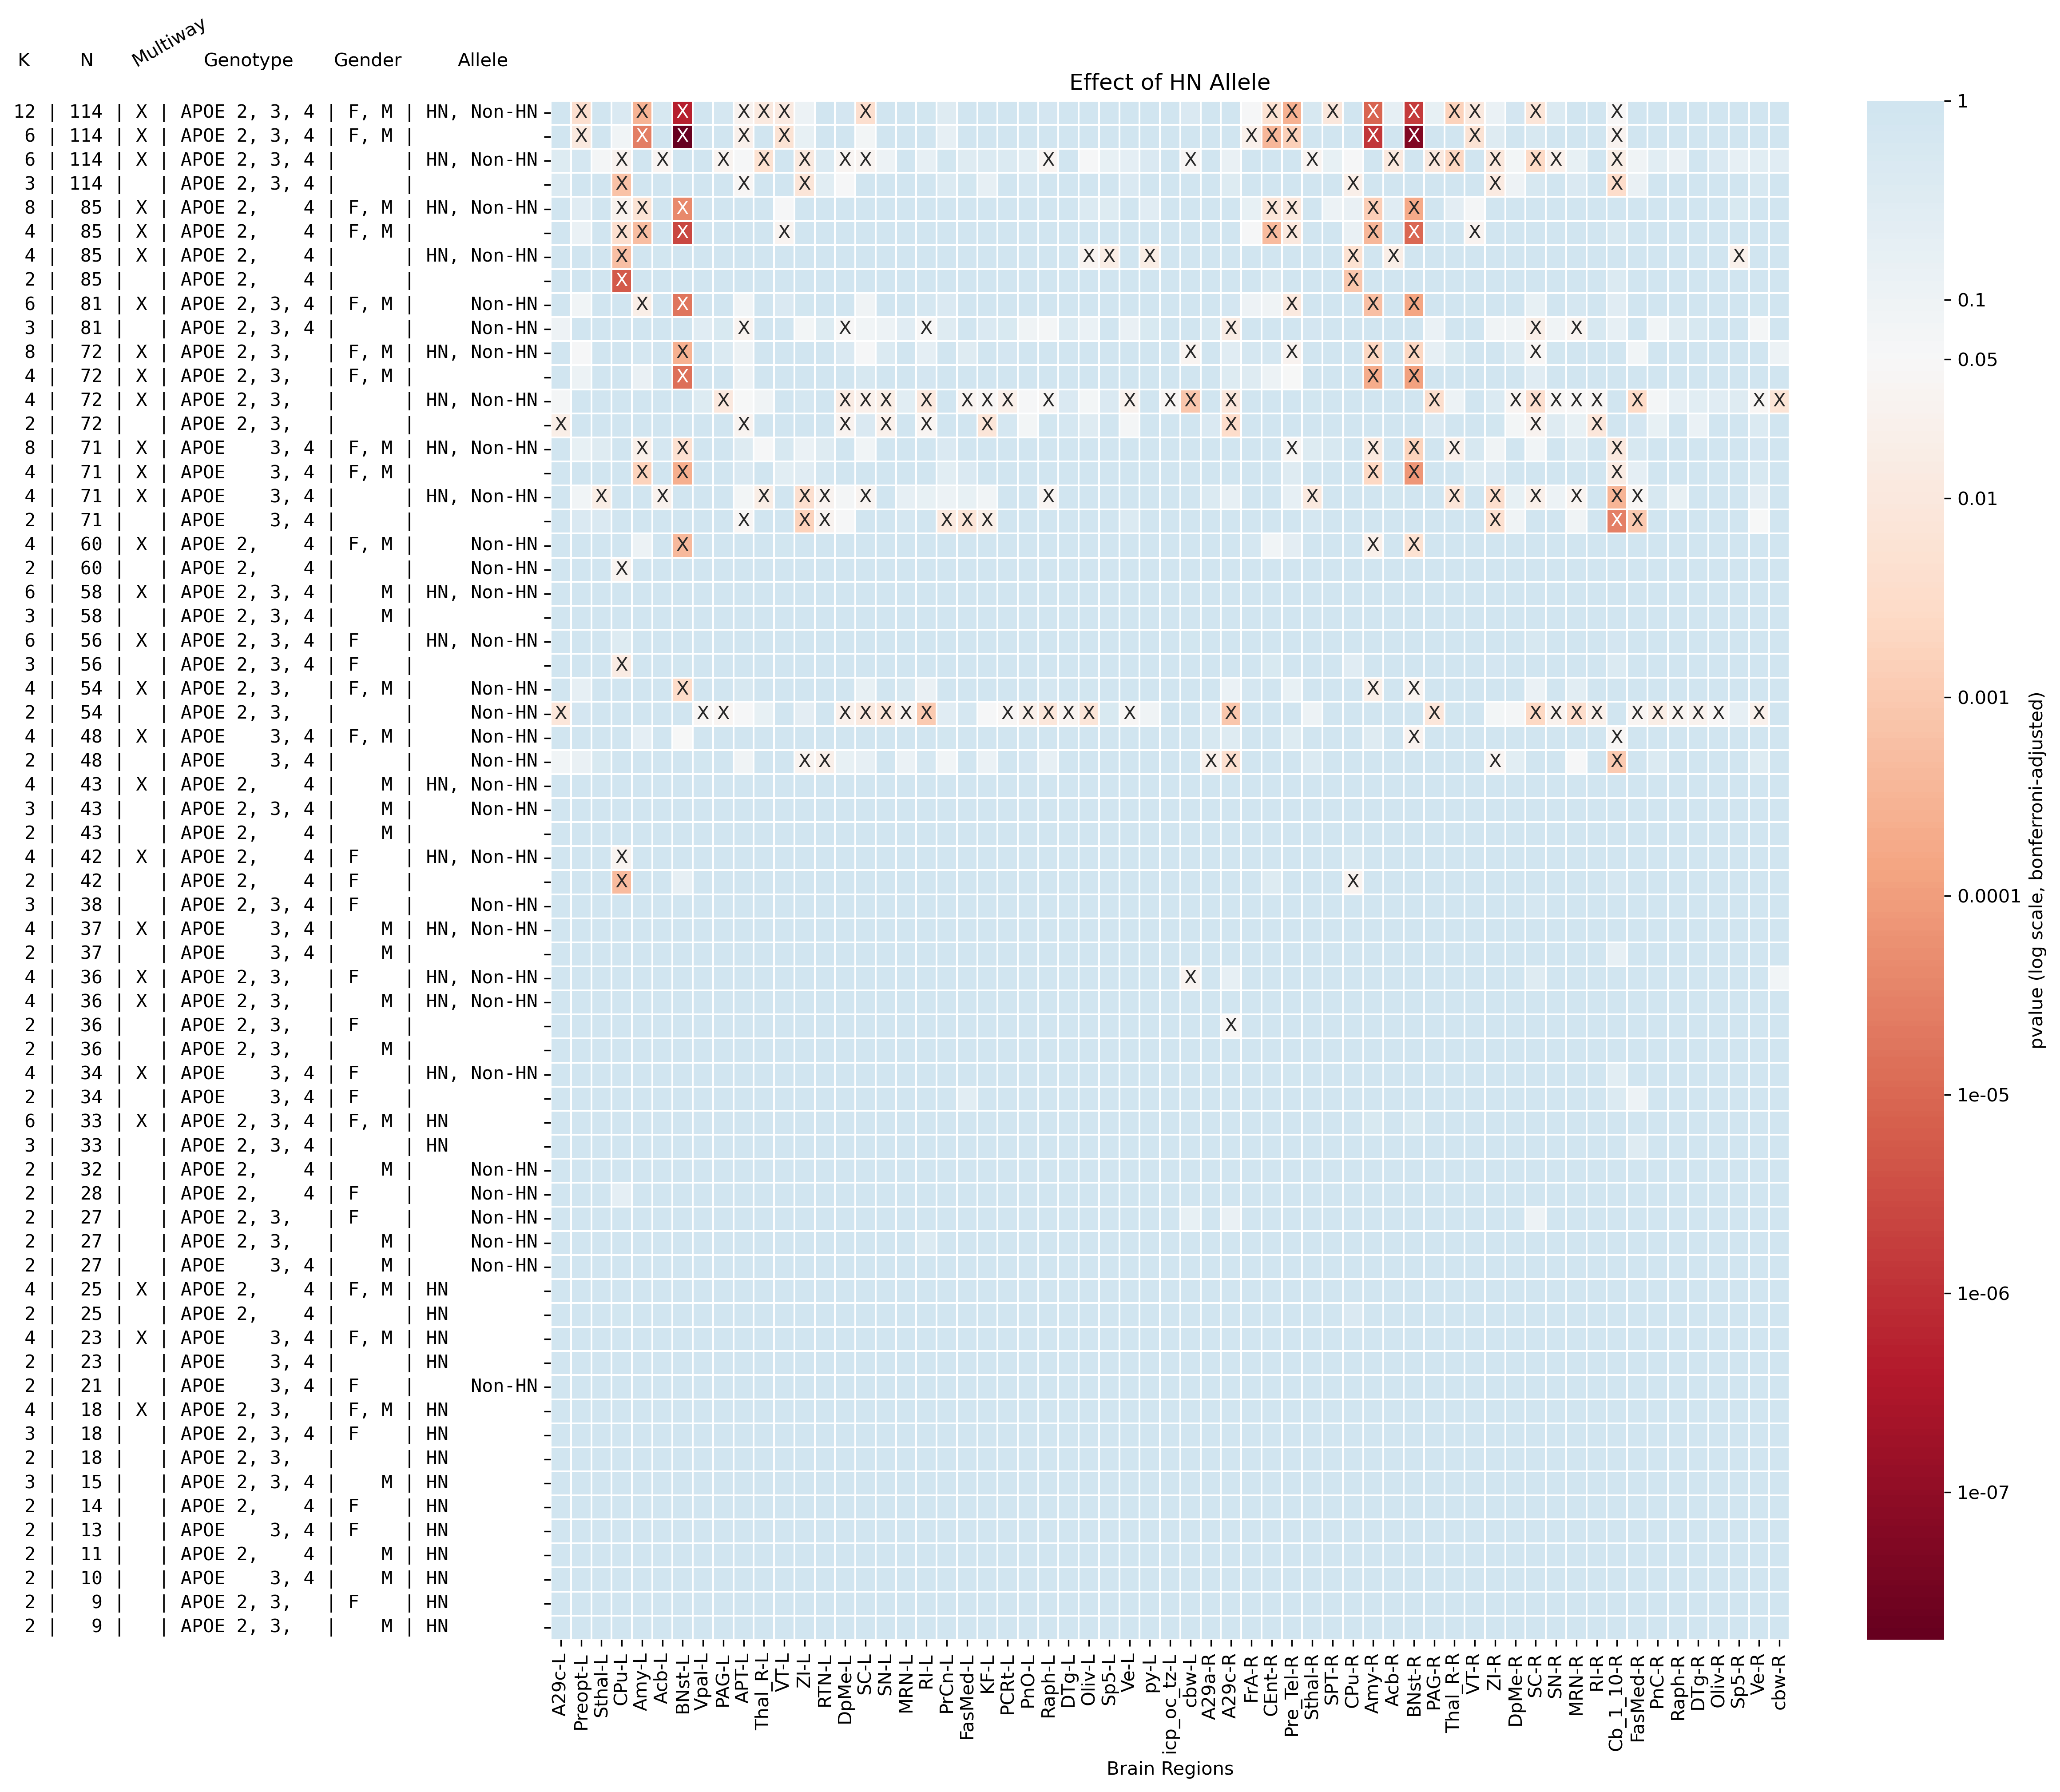

In [4]:
cbar_ticks = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 1]

fig, ax = plt.subplots(figsize=(15, 15), dpi=300)
sns.heatmap(
    pvalues.transform("log10").iloc[:, nodes_to_choose],
    ax=ax,
    annot=mask[:, nodes_to_choose][:, :],
    fmt="",
    square=False,
    linewidths=0.5,
    center=np.log10(0.05),
    cbar_kws={"ticks": np.log10(cbar_ticks)},
    cmap="RdBu",
    # xticklabels=False,
)

ax.collections[0].colorbar.set_label("pvalue (log scale, bonferroni-adjusted)")
ax.collections[0].colorbar.set_ticklabels(cbar_ticks)

ax.set_yticklabels(ax.get_yticklabels(), ha="right", fontdict={"family": "monospace"})
ax.set_xlabel("Brain Regions")
ax.set_title("Effect of HN Allele")

# for i, name in enumerate(["K", "Multiway", "APOE2", "APOE3", "APOE4", "Sex", "Allele"]):
#     ax.text(
#         xposition + (i * gap),
#         1.02,
#         name,
#         ha="left",
#         va="bottom",
#         rotation=rot,
#         transform=ax.transAxes,
#     )

text_dict = dict(ha="left", va="bottom", transform=ax.transAxes)

ax.text(-0.43, 1.02, "K", **text_dict)
ax.text(-0.38, 1.02, "N", **text_dict)
ax.text(-0.34, 1.02, "Multiway", rotation=30, **text_dict)
ax.text(-0.28, 1.02, "Genotype", **text_dict)
ax.text(-0.175, 1.02, "Gender", **text_dict)
ax.text(-0.075, 1.02, "Allele", **text_dict)


fig.savefig("../results/figures/allele_tests_all.png", bbox_inches="tight", dpi=300)

## Examining the effect of allele and gender.

Here, we only consider mice with control diet due to missing data. In the figure below, each row represents type of mice being considered, and each column represents a brain region. For sake of visualization, we only show the brain regions and mice groups in which there is at least one significant result. The p-values are first corrected via Bonferroni with significance level a = 0.05. The left text columns specify the type of mice under consideration. For example, the first row denote tests consisting of APOE2, 3, 4, with both genders and both alleles. A blank group denotes when that particular label is ignored. For example, in the second row, we ignore the labels of allele, while in third row, we ignore the labels of gender. 

These sequencial tests allow for testing of how each factor (gender, allele) affects the results. For example, the CPu region of left hemisphere show significant difference among the three genotypes and the HN and non-HN groups. However, this difference is not detected when gender is considered, suggesting that gender has no influence on differences of CPu brain region. Similar logic can be applied to different brain regions.

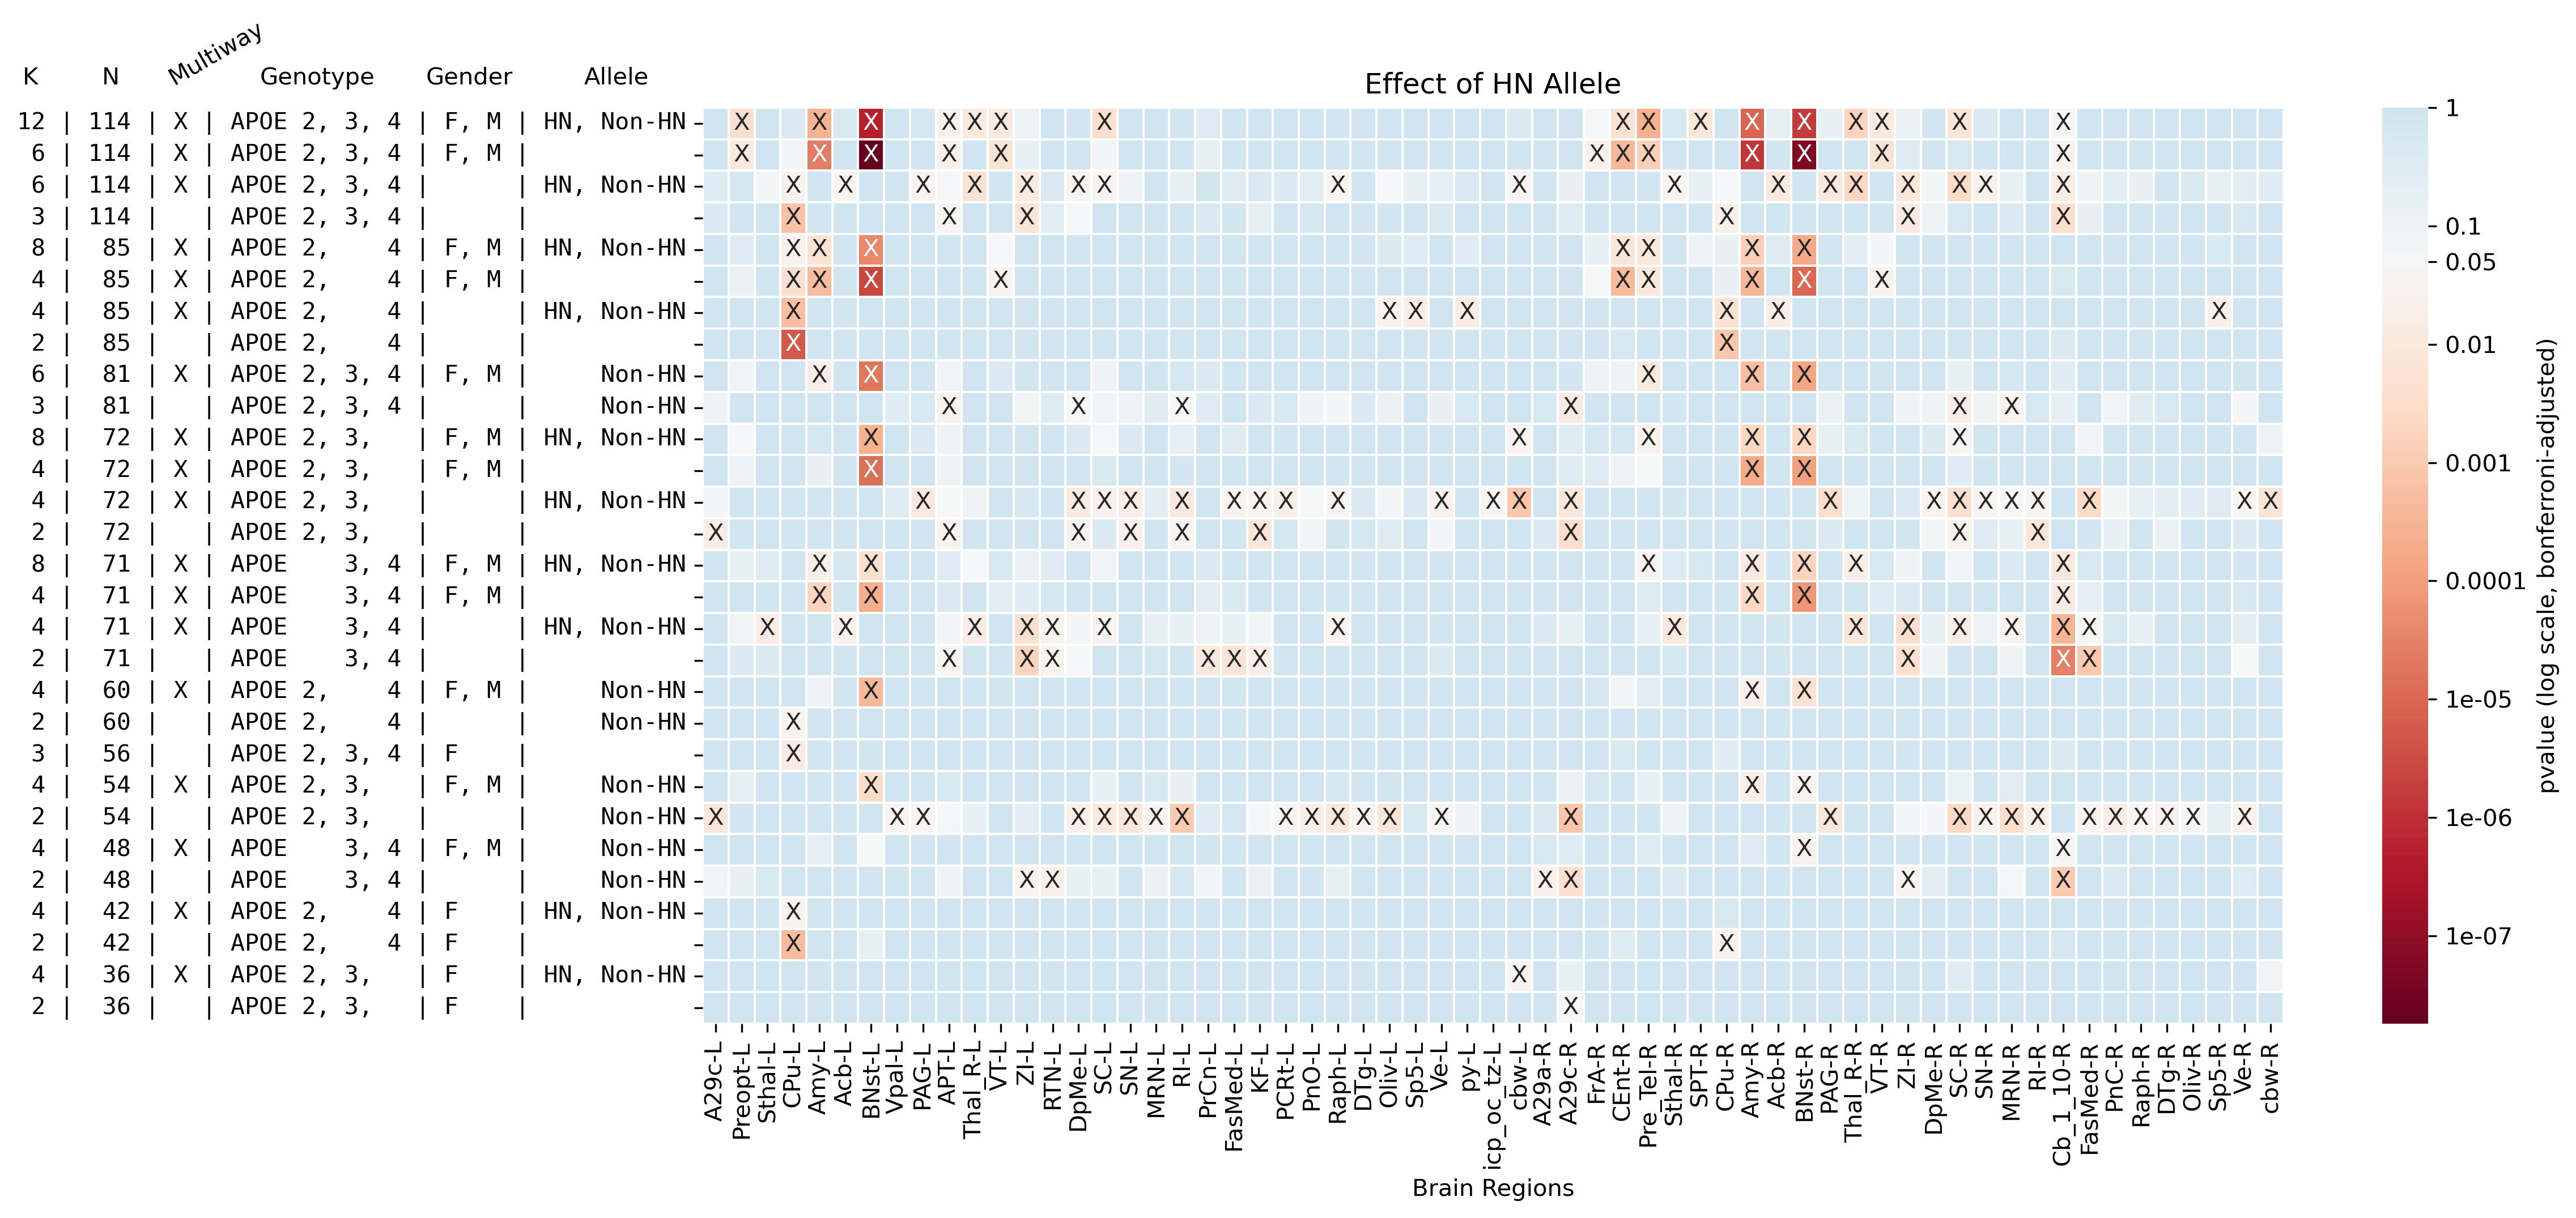

In [5]:
cbar_ticks = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 1]

fig, ax = plt.subplots(figsize=(15, 7), dpi=300)
sns.heatmap(
    pvalues.transform("log10").iloc[rows_to_choose, nodes_to_choose],
    ax=ax,
    annot=mask[:, nodes_to_choose][rows_to_choose, :],
    fmt="",
    square=False,
    linewidths=0.5,
    center=np.log10(0.05),
    cbar_kws={"ticks": np.log10(cbar_ticks)},
    cmap="RdBu",
    # xticklabels=False,
)

ax.collections[0].colorbar.set_label("pvalue (log scale, bonferroni-adjusted)")
ax.collections[0].colorbar.set_ticklabels(cbar_ticks)

ax.set_yticklabels(ax.get_yticklabels(), ha="right", fontdict={"family": "monospace"})
ax.set_xlabel("Brain Regions")
ax.set_title("Effect of HN Allele")

text_dict = dict(ha="left", va="bottom", transform=ax.transAxes)

ax.text(-0.43, 1.02, "K", **text_dict)
ax.text(-0.38, 1.02, "N", **text_dict)
ax.text(-0.34, 1.02, "Multiway", rotation=30, **text_dict)
ax.text(-0.28, 1.02, "Genotype", **text_dict)
ax.text(-0.175, 1.02, "Gender", **text_dict)
ax.text(-0.075, 1.02, "Allele", **text_dict)

fig.savefig(
    "../results/figures/allele_tests_significant_only.png", bbox_inches="tight", dpi=300
)

In [32]:
groups = [
    ["Sex_Female", "Sex_Male", "Allele_HN", "Diet_HFD", "Diet_Control"],
    ["Sex_Female", "Allele_HN", "Diet_HFD", "Diet_Control"],
    ["Sex_Male", "Allele_HN", "Diet_HFD", "Diet_Control"],
    ["Sex_Female", "Sex_Male", "Allele_HN", "Diet_HFD"],
    ["Sex_Female", "Sex_Male", "Allele_HN", "Diet_Control"],
    ["Sex_Female", "Allele_HN", "Diet_HFD"],
    ["Sex_Female", "Allele_HN", "Diet_Control"],
    ["Sex_Male", "Allele_HN", "Diet_HFD"],
    ["Sex_Male", "Allele_HN", "Diet_Control"],
    ["Allele_HN", "Diet_HFD", "Diet_Control"],
    ["Allele_HN", "Diet_HFD"],
    ["Allele_HN", "Diet_Control"],
    ["Sex_Male", "Allele_HN"],
    ["Sex_Female", "Allele_HN"],
    ["Sex_Male", "Sex_Female", "Allele_HN"],
    ["Allele_HN"],
]

genotype_groups = []
for i in [3, 2]:
    genotype_groups += list(
        combinations(["Genotype_APOE22", "Genotype_APOE33", "Genotype_APOE44"], i)
    )
genotype_groups = [list(i) for i in genotype_groups]

TEST_LIST = [i + j for i in genotype_groups for j in groups]


res = []

for test in TEST_LIST:
    lookup_codes = [lookup[i] for i in test]
    test_multiway_table = multiway_table[:, lookup_codes]
    maximum = np.max(test_multiway_table.sum(axis=1))

    idx = test_multiway_table.sum(axis=1) == maximum

    x = vols[idx]
    y = test_multiway_table[idx]

    n = x.shape[0]

    tmp_res = []
    for i in range(x.shape[1]):
        stat, pval = chi2_approx(Dcorr().statistic, x[:, [i]], y)
        tmp_res.append(pval)

    apoe2 = True if "Genotype_APOE22" in test else False
    apoe3 = True if "Genotype_APOE33" in test else False
    apoe4 = True if "Genotype_APOE44" in test else False
    female = True if "Sex_Female" in test else False
    male = True if "Sex_Male" in test else False
    hfd = True if "Diet_HFD" in test else False
    control_diet = True if "Diet_Control" in test else False
    multiway = True if (female and male) or (hfd and control_diet) else False

    res.append(
        [multiway, apoe2, apoe3, apoe4, female, male, hfd, control_diet, n, *tmp_res]
    )


columns = [
    "Multiway",
    "APOE2",
    "APOE3",
    "APOE4",
    "Female",
    "Male",
    "HFD",
    "Control_Diet",
    "N",
] + volumes.structure.to_list()

df = pd.DataFrame(res, columns=columns)


K = []

for idx, row in df.iterrows():
    total = row[["APOE2", "APOE3", "APOE4"]].sum()
    if row[["Female", "Male"]].sum() > 0:
        total *= row[["Female", "Male"]].sum()
    if row[["HFD", "Control_Diet"]].sum() > 0:
        total *= row[["HFD", "Control_Diet"]].sum()
    K.append(total)

df["K"] = K

df.sort_values(
    by=["N", "K", "Female", "Male", "Control_Diet", "HFD", "K"],
    inplace=True,
    ascending=False,
)

i_new = []
for idx, row in df.iterrows():
    K = row["K"]
    N = row["N"]
    if row["Multiway"]:
        multiway = "X"
    else:
        multiway = " "

    geno_row = row[["APOE2", "APOE3", "APOE4"]]
    if np.all(geno_row == [True, True, True]):
        genotype = "APOE 2, 3, 4"
    elif np.all(geno_row == [True, True, False]):
        genotype = "APOE 2, 3,  "
    elif np.all(geno_row == [True, False, True]):
        genotype = "APOE 2,    4"
    elif np.all(geno_row == [False, True, True]):
        genotype = "APOE    3, 4"
    else:
        genotype = "            "

    gender_row = row[["Female", "Male"]]
    if np.all(gender_row == [True, True]):
        gender = "F, M"
    elif np.all(gender_row == [False, True]):
        gender = "   M"
    elif np.all(gender_row == [True, False]):
        gender = "F   "
    else:
        gender = "    "

    diet_row = row[["Control_Diet", "HFD"]]
    if np.all(diet_row == [True, True]):
        diet = "Control, HFD"
    elif np.all(diet_row == [False, True]):
        diet = "         HFD"
    elif np.all(diet_row == [True, False]):
        diet = "Control     "
    else:
        diet = "            "

    index = f"{K:2d} | {N:3d} | {multiway} | {genotype} | {gender} | {diet}"
    i_new.append(index)
df.index = i_new

pvalues = df.iloc[:, 9:-1].copy()

sig, corrected_pvals, b, alpha = multipletests(
    pvalues.values.ravel(), method="bonferroni"
)

pvalues.iloc[:, :] = corrected_pvals.reshape(len(TEST_LIST), -1)
mask = np.select([pvalues < 0.05, pvalues >= 0.05], ["X", ""], default=pvalues)


nodes_to_choose = ((pvalues <= 0.05).sum() >= 1).values
pvalues.columns = node_labels["Abbreviation-Hemisphere"].values

left_idx = nodes_to_choose & left_nodes
right_idx = nodes_to_choose & right_nodes

rows_to_choose = ((pvalues <= 0.05).sum(axis=1) >= 1).values

## Examining the effect of diet and gender.

Here, we only consider mice with the HN allele due to missing data.

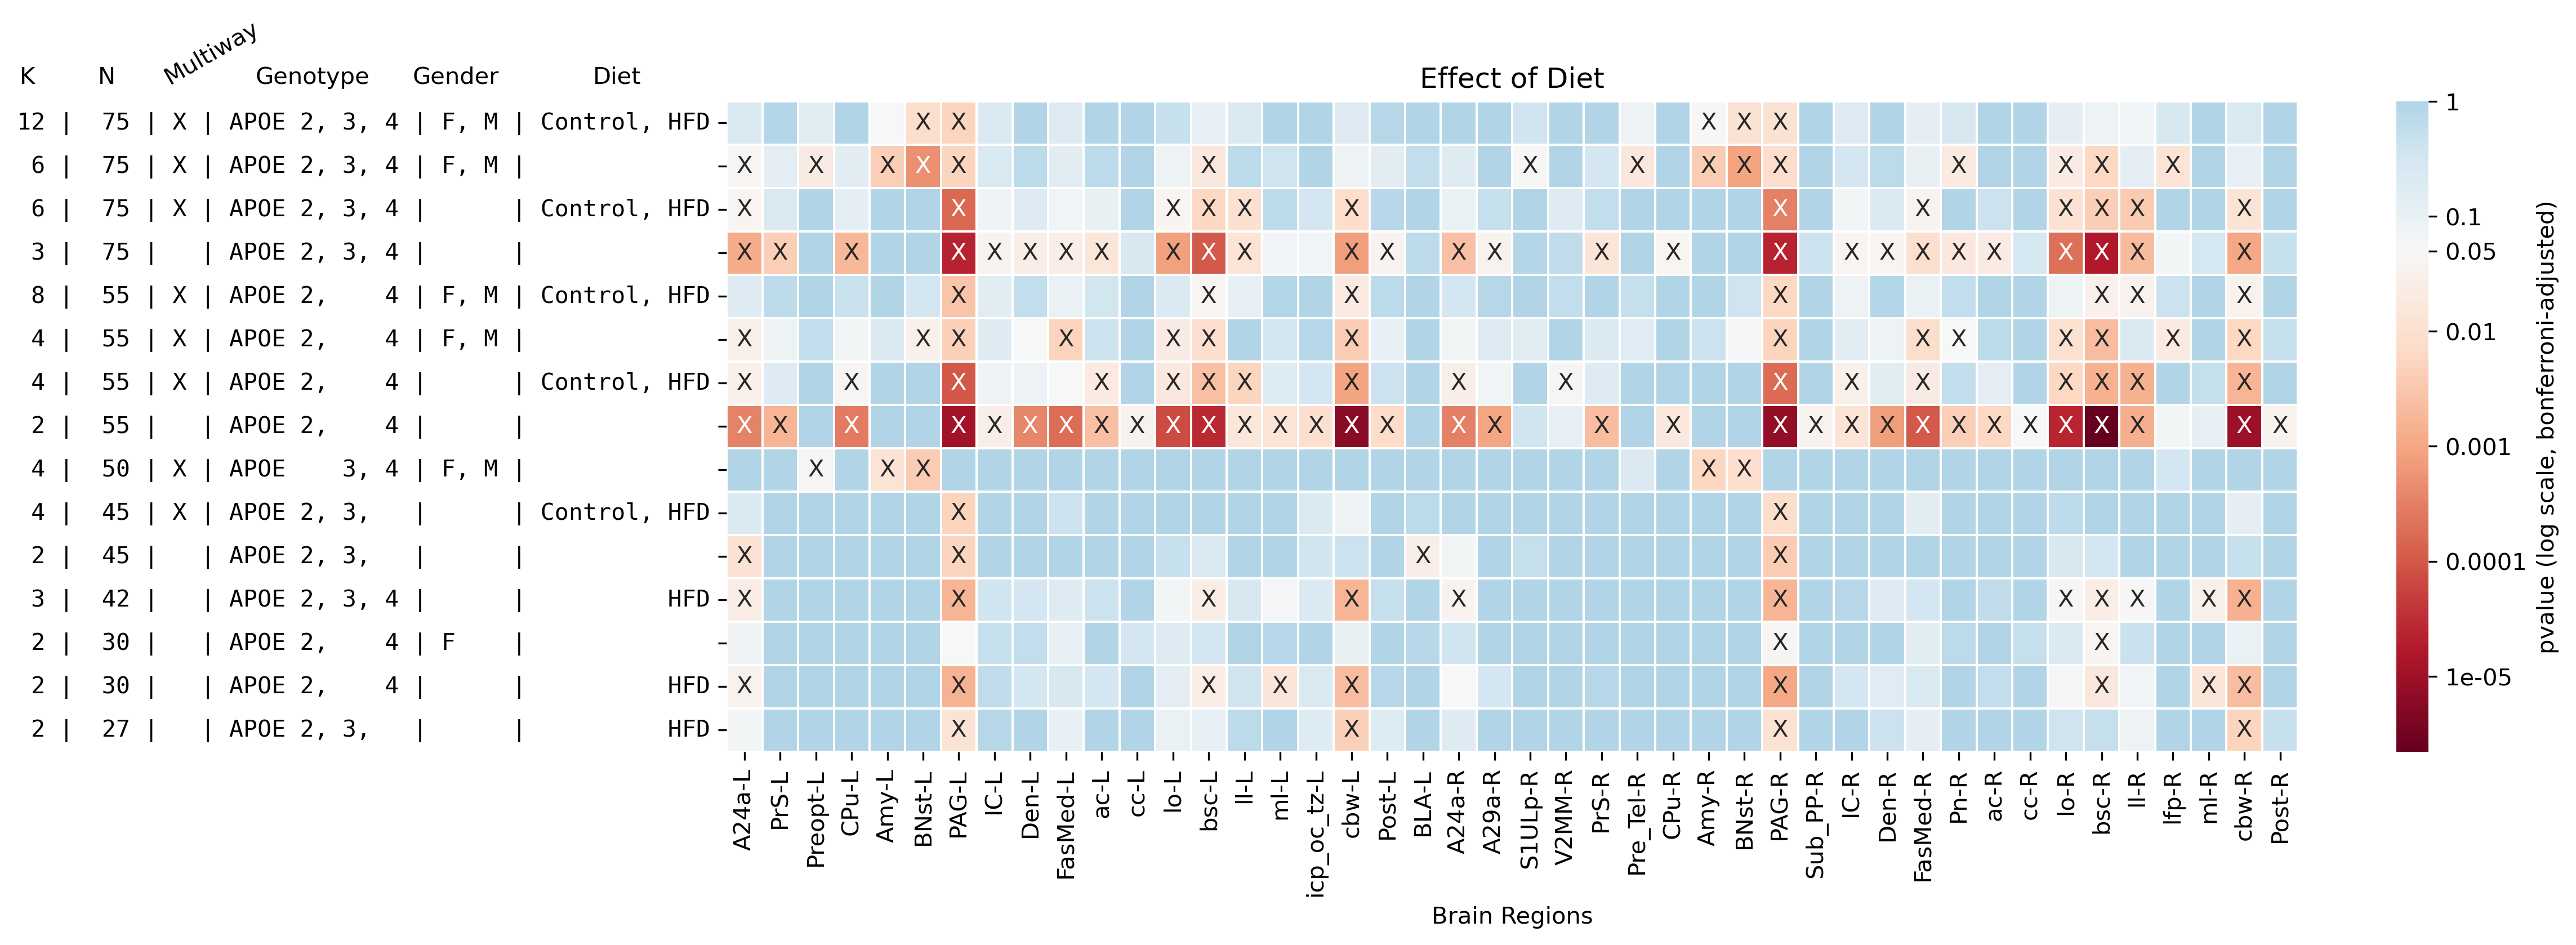

In [35]:
cbar_ticks = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 1]

fig, ax = plt.subplots(figsize=(15, 5), dpi=300)
sns.heatmap(
    pvalues.transform("log10").iloc[rows_to_choose, nodes_to_choose],
    ax=ax,
    annot=mask[:, nodes_to_choose][rows_to_choose, :],
    fmt="",
    square=False,
    linewidths=0.5,
    center=np.log10(0.05),
    cbar_kws={"ticks": np.log10(cbar_ticks)},
    cmap="RdBu",
    # xticklabels=False,
)

ax.collections[0].colorbar.set_label("pvalue (log scale, bonferroni-adjusted)")
ax.collections[0].colorbar.set_ticklabels(cbar_ticks)

ax.set_yticklabels(ax.get_yticklabels(), ha="right", fontdict={"family": "monospace"})
ax.set_xlabel("Brain Regions")
ax.set_title("Effect of Diet")

text_dict = dict(ha="left", va="bottom", transform=ax.transAxes)

ax.text(-0.45, 1.02, "K", **text_dict)
ax.text(-0.4, 1.02, "N", **text_dict)
ax.text(-0.36, 1.02, "Multiway", rotation=30, **text_dict)
ax.text(-0.3, 1.02, "Genotype", **text_dict)
ax.text(-0.2, 1.02, "Gender", **text_dict)
ax.text(-0.085, 1.02, "Diet", **text_dict)

fig.savefig(
    "../results/figures/diet_tests_significant_only.png", bbox_inches="tight", dpi=300
)